In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In C:\Users\shubh\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shubh\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shubh\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\shubh\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\shubh\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [100, 80, 100] # known

In [3]:
N_OBS = [30, 20, 2]

In [4]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

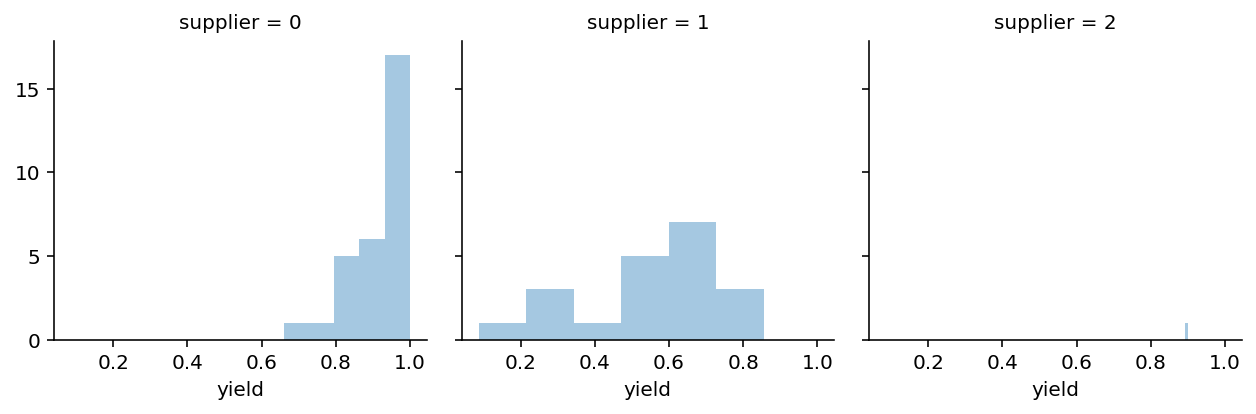

In [5]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

In [6]:
SALES_PRICE = 500 
HOLDING_COST = 100

In [7]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per launch
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

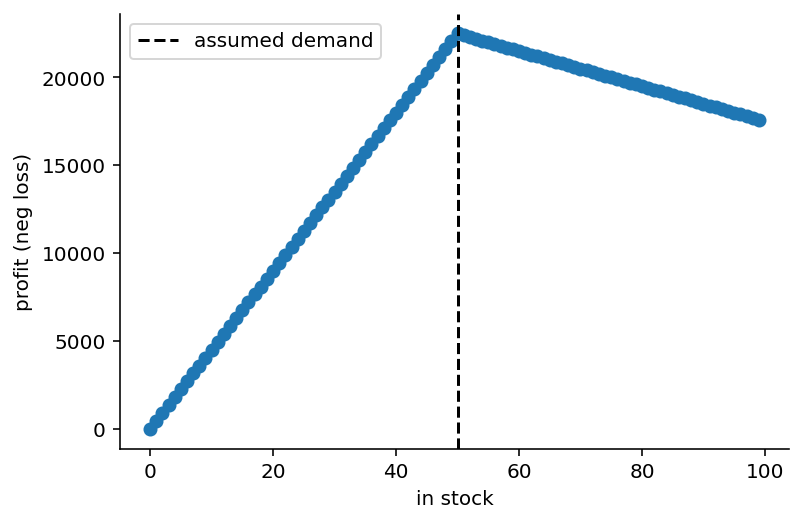

In [8]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50)); plt.axvline(50, c='k', ls='--', label='assumed demand');
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)'); sns.despine(); plt.legend();

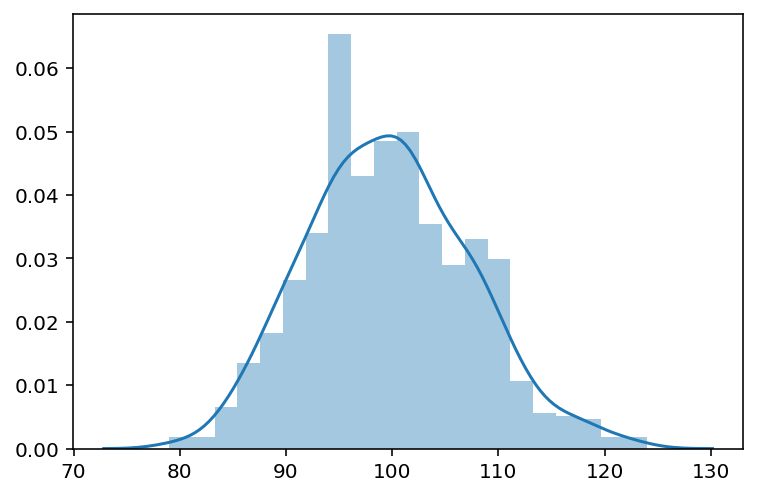

In [9]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

In [10]:
demand_samples

array([ 96,  84,  91,  99,  94, 105, 101, 102, 109, 110, 105,  92,  94,
       108,  97,  90,  94, 108,  93,  90, 106,  96, 103, 114, 100, 107,
        93,  98,  95,  98,  92, 108, 104,  99, 109,  96,  84, 104,  94,
        89,  99, 109,  86, 101, 113,  99, 102,  95,  98, 103,  83,  89,
       108, 107,  90, 113, 105, 101, 112, 102, 101,  92,  91, 115,  89,
        97,  94,  88,  89, 100,  99, 102, 100, 102,  99,  92, 101, 107,
        99, 108, 107, 111, 101, 101, 104,  97, 102,  96,  92, 103,  97,
       104, 100,  89, 105,  90,  91,  99, 100,  91,  93,  97,  98,  89,
       111,  86,  89,  90, 106, 109, 100, 104, 100, 101, 101,  90,  92,
       101, 100, 109, 109,  94,  96, 116, 101,  91,  88, 102, 104, 100,
        94,  89,  98, 109,  97,  96, 113, 104,  93, 103, 104,  99,  97,
       112,  95, 100,  95,  95,  95,  96,  96, 108, 100,  98, 119, 105,
        99,  98,  99,  93, 105,  97,  93,  94,  97,  94,  92, 116, 110,
        96, 105, 102, 103, 110, 101, 103,  99,  98, 100,  94, 11

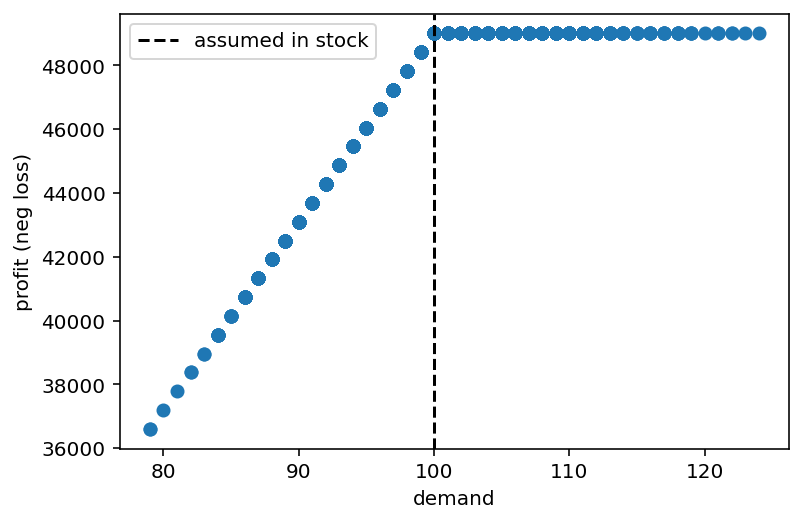

In [11]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

In [12]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3)
    β = pm.HalfNormal('β', sd=10., shape=3)
    
    # Different likelihood for every supplier because we have different number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 237 seconds.


In [13]:
trace

<MultiTrace: 2 chains, 1000 iterations, 4 variables>

C:\Users\shubh\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


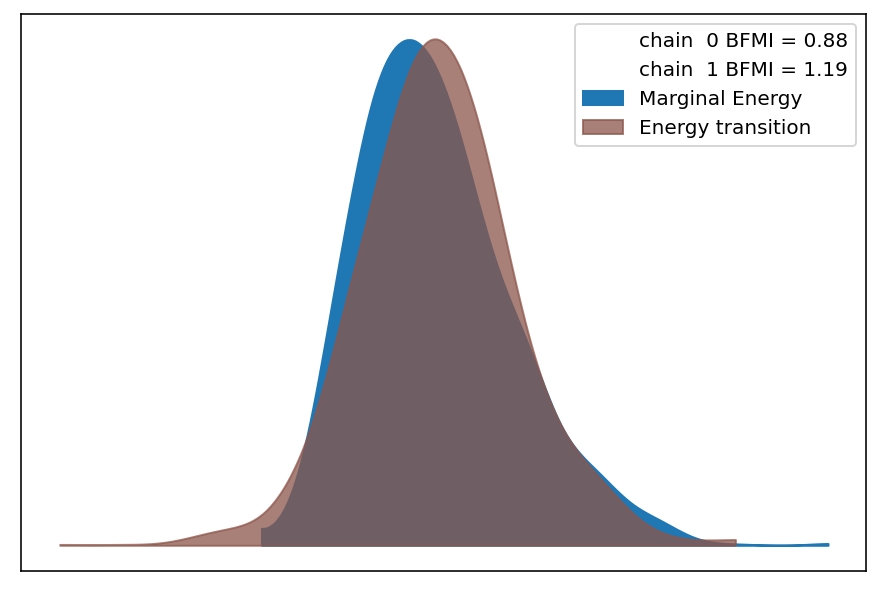

In [14]:
# make sure convergence looks good
az.plot_energy(trace);

C:\Users\shubh\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'α\n0'}>,
        <AxesSubplot:title={'center':'α\n0'}>],
       [<AxesSubplot:title={'center':'α\n1'}>,
        <AxesSubplot:title={'center':'α\n1'}>],
       [<AxesSubplot:title={'center':'α\n2'}>,
        <AxesSubplot:title={'center':'α\n2'}>],
       [<AxesSubplot:title={'center':'β\n0'}>,
        <AxesSubplot:title={'center':'β\n0'}>],
       [<AxesSubplot:title={'center':'β\n1'}>,
        <AxesSubplot:title={'center':'β\n1'}>],
       [<AxesSubplot:title={'center':'β\n2'}>,
        <AxesSubplot:title={'center':'β\n2'}>]], dtype=object)

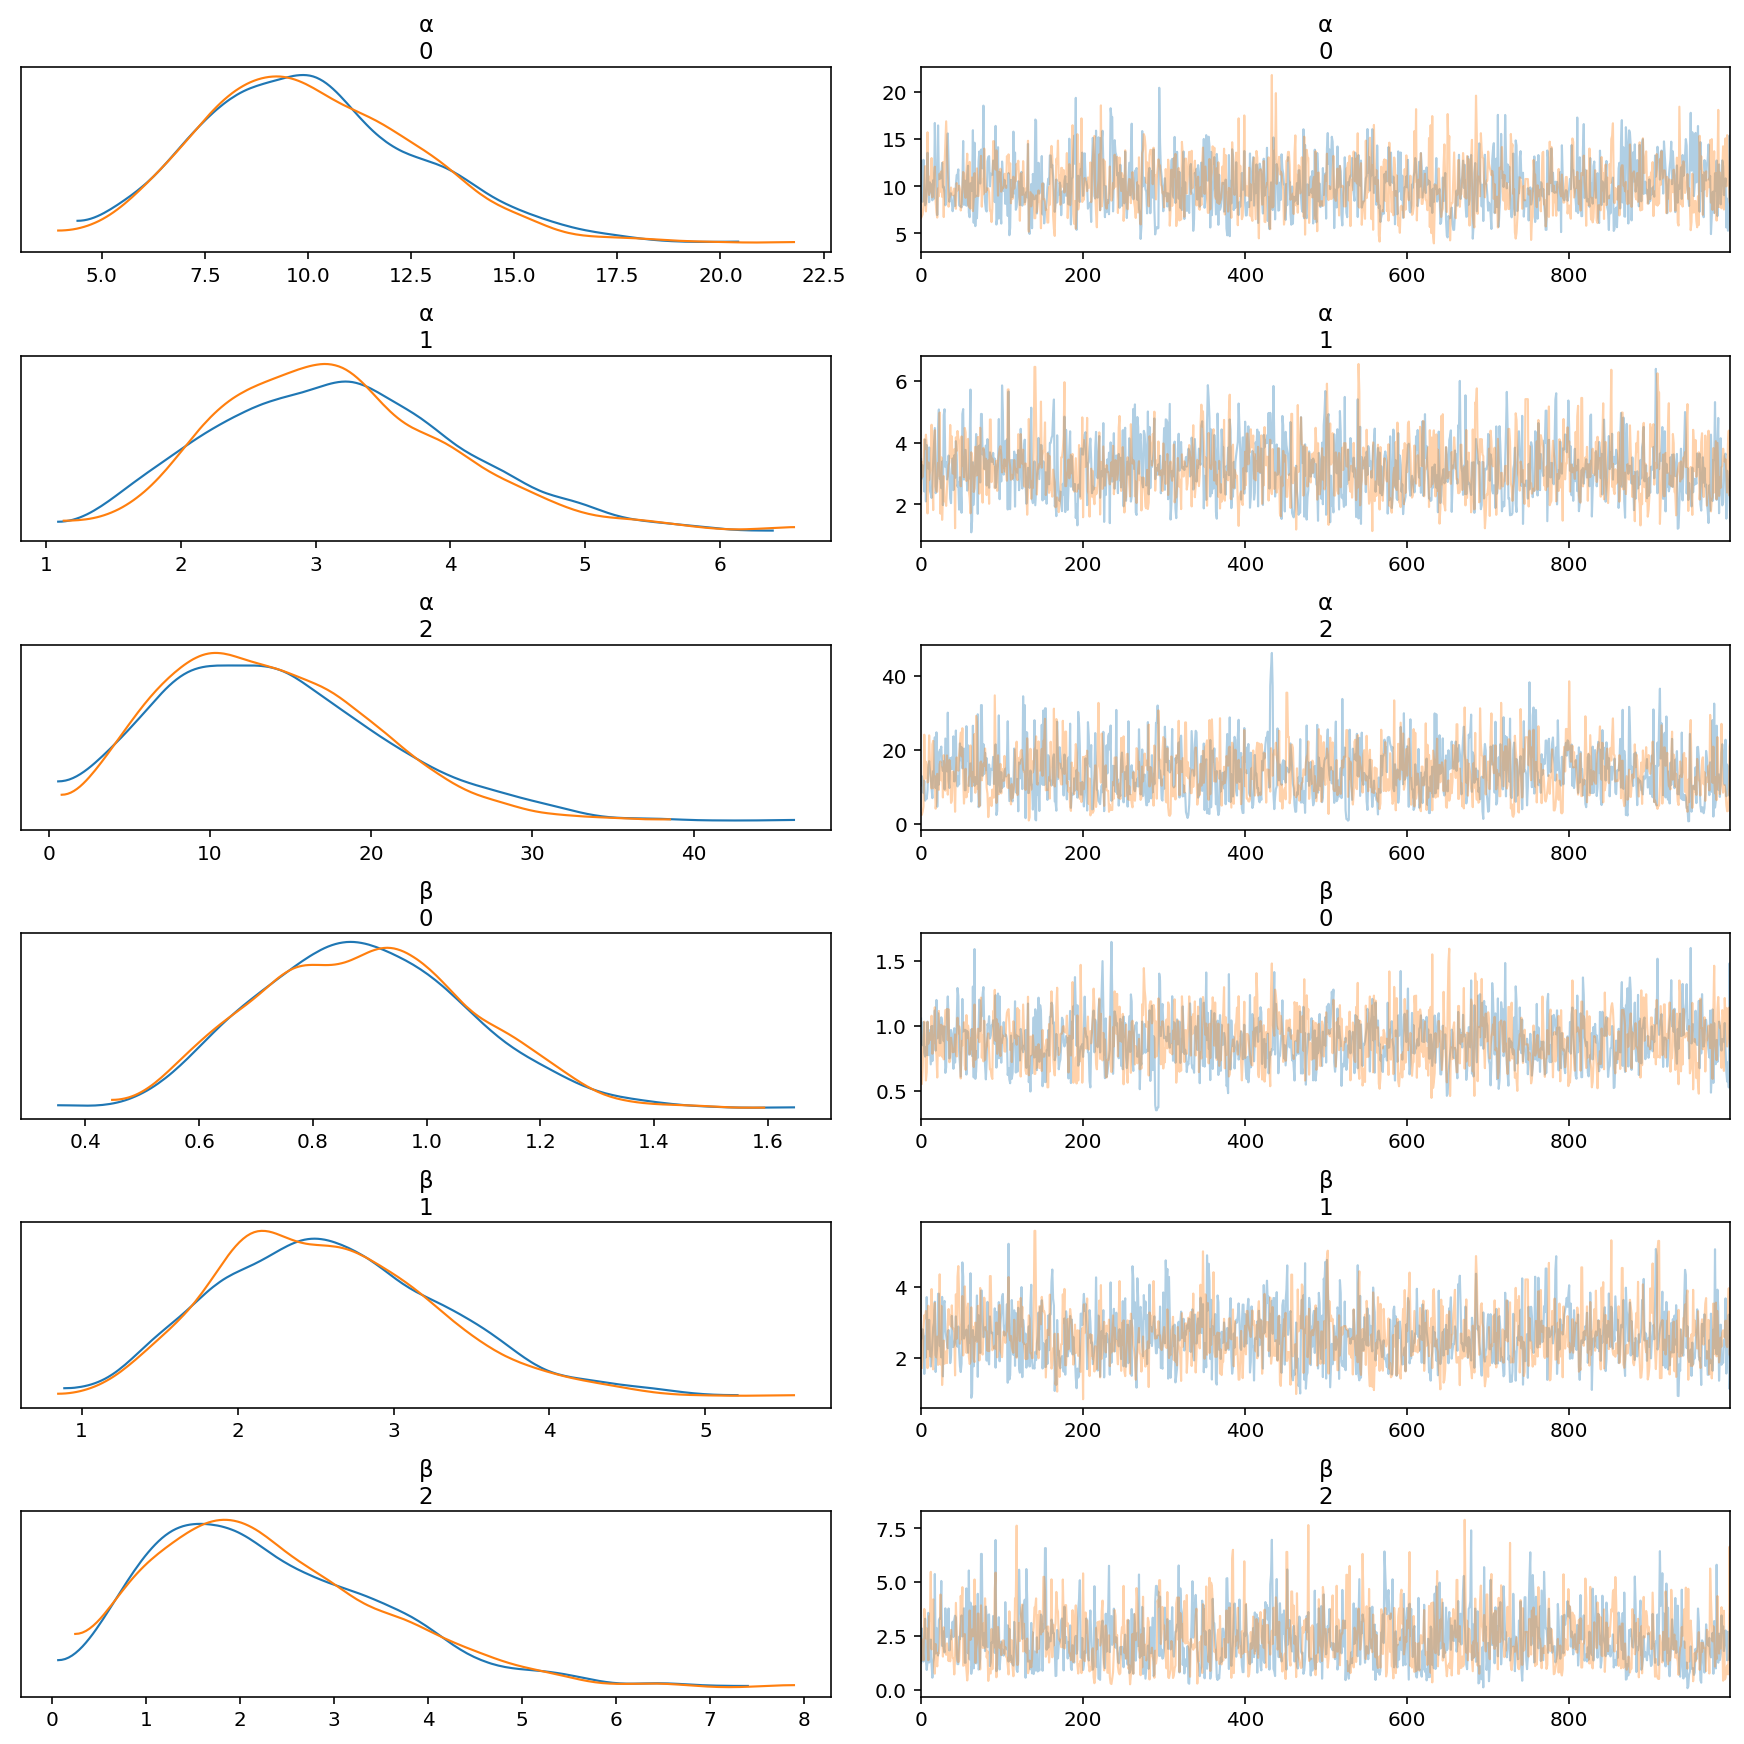

In [15]:
az.plot_trace(trace)

In [16]:
az.summary(trace)

C:\Users\shubh\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],10.108,2.641,5.382,14.993,0.072,0.053,1357.0,1238.0,1397.0,1151.0,1.0
α[1],3.177,0.901,1.638,4.942,0.024,0.017,1447.0,1401.0,1437.0,1310.0,1.0
α[2],13.851,6.751,2.084,25.863,0.207,0.147,1060.0,1060.0,994.0,884.0,1.0
β[0],0.895,0.192,0.558,1.239,0.005,0.004,1331.0,1331.0,1303.0,1190.0,1.0
β[1],2.614,0.749,1.311,4.008,0.020,0.014,1409.0,1372.0,1409.0,1265.0,1.0
β[2],2.352,1.247,0.427,4.645,0.038,0.027,1075.0,1075.0,947.0,1011.0,1.0


In [17]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

C:\Users\shubh\Anaconda3\lib\site-packages\pymc3\sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


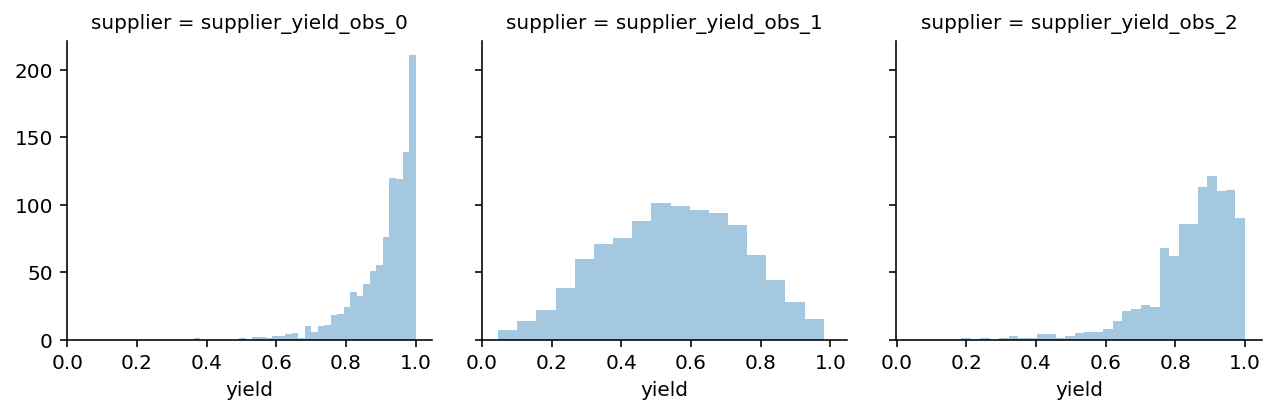

In [18]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

In [19]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

In [20]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

In [21]:
from scipy import optimize

In [22]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

In [23]:
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

In [24]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

Optimal order amount from every supplier = [  0.  80. 100.]


In [25]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

Total order amount from all suppliers = 180.0
